In [1]:
import os 
from pyMFI import MFI
import scipy
from pyMFI import MFI1D
from pyMFI import run_plumed

import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob
import sys

#Analytical surface
x = np.linspace(-2, 2, 201)
y = 7*x**4-23*x**2
y = y - min(y)

os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

## Run WT-MetaD simulation

In [15]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

simulation_steps = 1000000
run_plumed.run_langevin1D_plumed_fes(length = simulation_steps, sigma=0.1, height=1, biasfactor=10, fes_stride = int(simulation_steps/100))

Running simulation


## Analyse with MFI

10.0%   OFE = 0.9694
20.0%   OFE = 0.7115
30.0%   OFE = 0.5972
40.0%   OFE = 0.5286
50.0%   OFE = 0.4667
60.0%   OFE = 0.4275
70.0%   OFE = 0.3968
80.0%   OFE = 0.3733
90.0%   OFE = 0.3503
100.0%   OFE = 0.3327


Text(0.5, 0, 'Number of Error Evaluations')

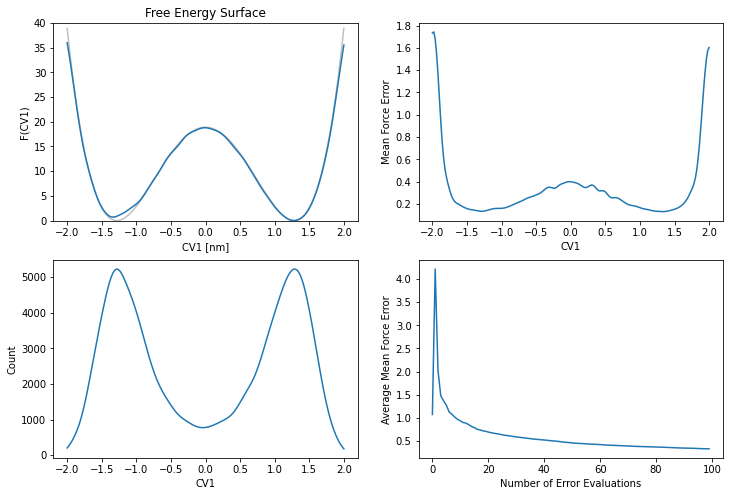

In [16]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

#Read the Colvar File
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force
[X, Ftot_den, Ftot, ofe, ofe_history, intermediate_fes_list] = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.1, kT = 1, min_grid=-2, 
                                                         max_grid=2, nbins=201, log_pace=10, error_pace=100, WellTempered=1, intermediate_fes_number=100)


# Integrate Ftot, obtain FES 
FES = MFI1D.intg_1D(X,Ftot)

# Plot Recap
lim=40
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(x, y, c="grey", alpha=0.5)
axs[0, 0].plot(X, FES)
axs[0, 0].set_ylim([0, lim])
axs[0, 0].set_ylabel('F(CV1)')
axs[0, 0].set_xlabel('CV1 [nm]')
axs[0, 0].set_title('Free Energy Surface')

axs[0, 1].plot(X, ofe);
axs[0, 1].set_ylabel('Mean Force Error')
axs[0, 1].set_xlabel('CV1')

axs[1, 0].plot(X, Ftot_den);
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xlabel('CV1')

axs[1, 1].plot(range(len(ofe_history)), ofe_history);
axs[1, 1].set_ylabel('Average Mean Force Error')
axs[1, 1].set_xlabel('Number of Error Evaluations')

100


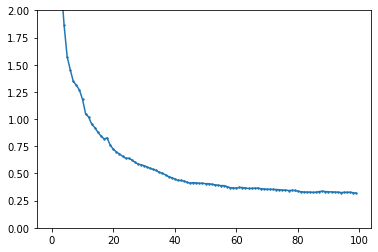

In [21]:
print(len(intermediate_fes_list))

AAD_progression = []
for i in range(len(intermediate_fes_list)):
    AAD_progression.append(sum(abs(y - intermediate_fes_list[i]))/len(y))
    
plt.plot(range(len(AAD_progression)), AAD_progression)
plt.scatter(range(len(AAD_progression)), AAD_progression, s=2)
plt.ylim(0,2)
plt.show()

error_progression_MFI = AAD_progression
    

## Analyse with sum_hills

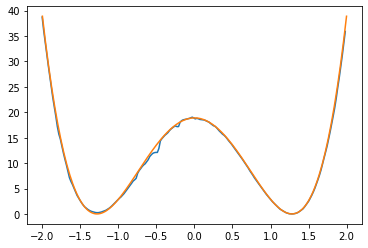

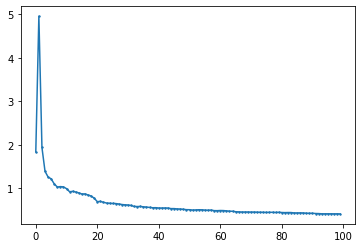

In [34]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")
error_progression = []

for filen in sorted(glob.glob( "analysis.*." + "fes.dat" ), key=os.path.getmtime) :
    data = np.loadtxt( filen )
    grid_data = data[:,0][50:251]
    fes_data = data[:,1][50:251]
    fes_data = fes_data - min(fes_data)
    diff = np.where(abs(fes_data) < 10**4, abs(y - fes_data), 0)
    error_progression.append((sum(diff)/np.count_nonzero(diff)))
        
for filen in glob.glob("fes.dat"):
    data = np.loadtxt( filen )
    grid_data = data[:,0][50:251]
    fes_data = data[:,1][50:251]
    fes_data = fes_data - min(fes_data)
    error_progression.append((sum(abs(y - fes_data))/len(y)))
    
    plt.plot(grid_data, fes_data)
    plt.plot(x,y)
    plt.show()
    
plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.show()

error_progression_wt_metad = error_progression


## Run (non-WT) MetaD simulation

In [38]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well/non_WT")

simulation_steps = 1000000
run_plumed.run_langevin1D_plumed_fes(length = simulation_steps, sigma=0.1, height=1, biasfactor=10**4, fes_stride = int(simulation_steps/100), grid_min=-4, grid_max=4, grid_bin=400)

os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

Running simulation


## Analyse with sum_hills

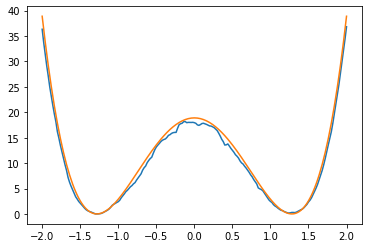

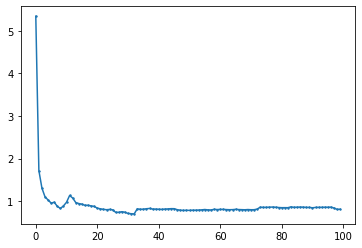

In [40]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well/non_WT")


error_progression = []

for filen in sorted(glob.glob( "analysis.*." + "fes.dat" ), key=os.path.getmtime) :
    data = np.loadtxt( filen ) 
    grid_data = data[:,0][100:301]
    fes_data = data[:,1][100:301]
    fes_data = fes_data - min(fes_data)
    diff = np.where(abs(fes_data) < 10**4, abs(y - fes_data), 0)
    error_progression.append((sum(diff)/np.count_nonzero(diff)))
    
for filen in glob.glob("fes.dat"):
    data = np.loadtxt( filen )
    grid_data = data[:,0][100:301]
    fes_data = data[:,1][100:301]
    fes_data = fes_data - min(fes_data)
    error_progression.append((sum(abs(y - fes_data))/len(y)))
    
    plt.plot(grid_data, fes_data)
    plt.plot(x, y)
    plt.show()
    
plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.show()

error_progression_metad = error_progression



os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

## Plot all

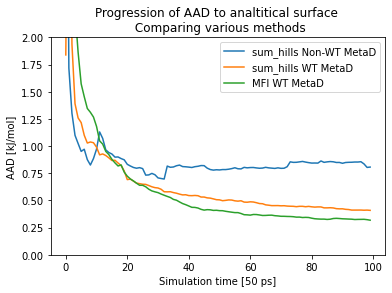

In [47]:
plt.plot(range(len(error_progression_metad)), error_progression_metad, label="sum_hills Non-WT MetaD")
plt.plot(range(len(error_progression_wt_metad)), error_progression_wt_metad, label="sum_hills WT MetaD")
plt.plot(range(len(error_progression_MFI)), error_progression_MFI, label="MFI WT MetaD")
plt.legend()
plt.xlabel("Simulation time [50 ps]")
plt.ylabel("AAD [kJ/mol]")
plt.title("Progression of AAD to analtitical surface \n Comparing various methods")
plt.ylim(0,2)
plt.show()